# CPN generator

## Table of contents
1. [Libraries](##Libraries)
2. [Language setting](##language-setting)
3. [Important functions](##important-functions)
4. [Data Cleaning](##data-cleaning)
5. [Word Embedding](##word-embedding)
6. [Model](##model)
7. [Experiments](##experiments)
8. [Search of hyperparameter *k*](##search-of-hyperparameter-k)


## [Libraries](##Libraries)

In [1]:
# Uncomment to install all the requirement
# ! pip install -r requirements.txt

In [1]:
import pandas as pd
import numpy as np
import spacy
import gensim
from collections import Counter 
import sklearn.cluster
from sklearn.model_selection import KFold
import random
from scipy.spatial import distance
import time

# Set of the random seed for the kmeans model
random.seed(0)

## [Important Variables](##important-variables)

In [3]:
# PATHS
# This the path to run the main example, for your data change the path to your data
 
pathData = r'../data/CPN120.csv'         # Path of the data to test the model
pathEmbedding = r'../data/SBW-vectors-300-min5.bin.gz'  # For example in Spanish

In [4]:
# VARIABLES
numberCluster = 500 # Number of clusters for the k-means model
language = "spanish" #you can change to "english" or your preference lenguage
embeddingLength = 300 # Change by the length of the embedding to be used

## [Language Setting](#language-setting)

In [5]:
# Data import
# Relative Path of the dataset, change for your dataset
data = pd.read_csv(pathData, delimiter=",")


if language=="spanish":
    # Import of the model of the spanish billion words embeddings
    model = gensim.models.KeyedVectors.load_word2vec_format( 
    pathEmbedding, # Relative path of the vector
    binary=True # The model is in binary format
    ) 
else:
    # Import of the model of the word2vec-google-news-300 for English dataset
    model = gensim.models.KeyedVectors.load_word2vec_format( 
    pathEmbedding, # Relative path of the vector
    binary=False # The model is in binary format
    )    


In [6]:
# For the model to work correctly, it needs 3 columns (Concept, Feature, and Code in that order), the name itself is not important.
# Code is important for the training of the model.
data.head(5) # Example with used dataset

,Concepto,Respuesta,Codigo
0,granito,tierra,terrestre
1,granito,rugoso,texturas
2,granito,construcción,material_construccion
3,granito,desagradable al tacto,texturas
4,granito,raspa,lastimar


Installation of the Spanish pipeline. Change depending on the language you are using it.

More info in the page of spacy.

In [7]:
# Download each one depending on your language preference
# if language=="spanish":
#     !python -m spacy download es_core_news_sm    
# else:
#     !python -m spacy download en_core_news_sm


In [8]:
# Configuration of spacy
if language=="spanish":
    nlp = spacy.load('es_core_news_sm')
else:
    nlp = spacy.load('en_core_news_sm')

## [Important functions](##important-functions)

In [9]:
def clean_text(text):
    """
    Receive a string and return tokens of each word, without punctuations
    and in lowercase
    """
    # for each token in the sentence, add the token to the list if is not a punctuation
    return [t for t in nlp(text.lower()) if not t.is_punct]


def normalize(tokens):
    """
    Receive al list of tokens and return in one string without stop words
    """
    # for each token if is not a stop word add the word to the list
    words = [t.orth_ for t in tokens if not t.is_stop]

    # return the tokens in one string
    return(" ".join(words))

def lemmatize(tokens):
    """
    Receive al list of tokens and return in one string without stop words 
    and Lemmatized
    """
    # for each token if is not a stop word add the lemma of the word in the list
    lemmas = [t.lemma_ for t in tokens if not t.is_stop]

    # return the tokens in one string
    return(" ".join(lemmas))


def to_vector(texto, model):
    """ 
    Receives a sentence string along with a word embedding model and 
    returns the vector representation of the sentence
    """
    tokens = texto.split() # splits the text by space and returns a list of words
    vec = np.zeros(embeddingLength) # creates an empty vector of 300 dimensions
    for word in tokens: # iterates over the sentence
        if word in model: # checks if the word is both in the word embedding
            vec += model[word] # adds every word embedding to the vector
    return vec / np.linalg.norm(vec) if np.linalg.norm(vec)>0 else vec # divides the vector by their normal

## [Data Cleaning](##data-cleaning)

In [10]:
start = time.time()
# Normalize of the features
for i in range(len(data)):
    # if you want to lemmatize change the function 'normalize()' to 'lemmatize()'
    data.iloc[i,1] = normalize(clean_text(data.iloc[i,1]))
end = time.time()

print("Execution time:", end-start)

Execution time: 97.46350955963135


## [Word Embedding](##word-embedding)

In [11]:
# Timer
start = time.time()

# Creation of a matrix full of 0 to save the vectors of each feature
descriptions_matrix = np.zeros( 
    (
        len(data), # the number of data points
        embeddingLength  # the number of components of the word embedding
    )
)

# Matrix filling with the vectors of each point
for i,description in enumerate(data.iloc[:,1]):
    vector = to_vector(description,model)
    descriptions_matrix[i,] = vector

# Concatenate the matrix with the data of each observation
data_matrix = np.concatenate([descriptions_matrix,data], axis=1)

# Remove of the 'Nan' values in the data
data_matrix = data_matrix[~pd.isnull(data_matrix[:,:300]).any(axis=1)]


end = time.time()
print("Execution time:", end-start)

Execution time: 2.110560894012451


## [Model](#model)

We create a class for the text classification, were initially you have to set the number of clusters you want to use for your model.

In [12]:
class AC_PLT:

    def __init__(self, n_clusters = 500, random_state=0):
        """
        n_clusters: number of cluster in the k-Means model
        """
        
        self.n_clusters = n_clusters            # Number of clusters
        self.KMeans_dict = {}                   # Dictionary of all the humans codifications for each Cluster
        self.KMeans_categories = {}             # Dictionary for the most frecuent value in the centroid
        self.km = sklearn.cluster.KMeans(       # Creates de k-means object
            n_clusters=self.n_clusters, 
            random_state=random_state,
            n_init='auto'
        )
        
    def most_frequent(self, List): 
        """
        Receives a list of codes, and return the most frequent code of
        the list
        """
        # Counter of occurence of a code in a list
        occurence_count = Counter(List) 
        
        # Return the first code with more occurence
        return occurence_count.most_common(1)[0][0] 


    def fit(self, train):
        """
        Receives the train dataset and fit the model of kmeans
        """
        # Train the k-means algorithm
        self.km.fit(train[:,:300])

        # Dataframe of train dataset
        df = pd.DataFrame(
            np.concatenate([
                np.reshape(train[:,302], (-1, 1)),          # Human codification
                np.reshape(self.km.labels_, (-1, 1)),       # Number of the KMean centroid
                np.reshape(train[:,300], (-1, 1))           # Concept of the codification
                ], axis=1), 
            columns=['Human', 'KMeans', 'Concept'])

        # Create a dictionary of all the humans codifications for each Cluster
        self.KMeans_dict = df.groupby(by='KMeans')['Human'].apply(list).to_dict()

        # Fill a dictionary with the most frecuent value in the centroid
        for key, val in self.KMeans_dict.items():
            self.KMeans_categories[key] = self.most_frequent(val)


    def get_distances(self, test):
        """
        Receives a dataset to calculate the distances from each property to 
        each centroid of the kmeans model, and returns a matrix with the 
        ordered distances.
        """
        
        # Distance matrix of each property of the dataset to each cluster centroid
        distance_matrix = distance.cdist(test[:,:300].astype(float), self.km.cluster_centers_, 'euclidean')
        
        # Sorting distances for each property
        self.topk=np.argsort(distance_matrix,axis=1)
        
    
    def set_labels(self, test):
        """
        Create a new matrix from the clusters sorted and change the value
        from numeric to the string according the codification
        """
        # Change of the numeric value to the codification string
        self.topKS=pd.DataFrame(self.topk)

        # Create a temporal array of the kmeans categories
        tempData = np.array([value for (_, value) in sorted(self.KMeans_categories.items())])
        
        # For each cluster center
        for j in range(self.topKS.shape[1]):
            # Set the codification of the numeric value in the topk list
            self.topKS.iloc[:,j]=tempData[self.topk[:,j]]


    def get_accuracies(self, test):
        """
        Receives the test matrix and return the accuracies of the 
        diferents predictions
        """
        # Creating the accuracy table to check each data point
        testLabel=np.zeros(self.topKS.shape)
        indexes_method0=pd.DataFrame(np.zeros((self.topKS.shape[0],2)), columns=['index', 'value']) 

        # For each data point
        for i in range(testLabel.shape[0]):
            # Checking if any of the clusters are able to classify it correctly
            boolClass=self.topKS.iloc[i,:]==test[i,302]
            if sum(boolClass)>0:
                getIndex=boolClass.idxmax()
                indexes_method0.iloc[i,0] = getIndex
                indexes_method0.iloc[i,1] = self.topKS.iloc[i,getIndex]
                #Setting the rest of the data point as 1
                testLabel[i,getIndex:]=1
            else:
                indexes_method0.iloc[i,0] = np.nan
                indexes_method0.iloc[i,1] = np.nan
        accuracies=testLabel.sum(axis=0)/testLabel.shape[0]

        return accuracies

    
    def transform(self, test):
        """
        Receives a dataframe and return the accuracy for each top n_clusters accuracy 
        sorted by distance
        """
        self.get_distances(test)
        self.set_labels(test)
        return self.get_accuracies(test)
    
    
    def suggestions(self, test, n_codes):
        """
        Receives a dataset and the number of suggestions wanted, and return a dataset 
        with the concept and property with the number of suggestions 
        """
        self.get_distances(test)
        self.set_labels()
        return pd.DataFrame(
            np.concatenate([
                np.reshape(test[:, 300], (-1, 1)),  # Concept
                np.reshape(test[:, 301], (-1, 1)),  # Property
                self.topKS.iloc[:, :n_codes]],
                axis=1
                ), 
            columns=['Concept', 'Property']+['top-{} suggestion'.format(i+1) for i in range(n_codes)]
            )
    
    def get_inertia(self): 
        """
        Return the inertia of the current model
        """
        return self.km.inertia_

## [Search of hyperparameter *k*](#search-of-hyperparameter-k)

In [2]:
rango = [50]+list(range(100,2500+1,100))
tops=[0,2,4,9,49] # The value of the top-p to assess their accurracy

k_acc_top_train = np.zeros((len(rango), 10)) # The top-p accurracy of the train dataset
k_acc_top_test = np.zeros((len(rango), 10)) # The top-p accurracy of the test dataset
k_sse = np.zeros((len(rango), 2)) # the inertia of the clusters formed

In [15]:
from sklearn.model_selection import KFold

j = 0
for k in rango:
    kfold=KFold(n_splits=5)

    train_temp = np.zeros((5,5))
    test_temp = np.zeros((5,5))
    sse = np.zeros(5)

    x = 0
    for train_index, test_index in kfold.split(data_matrix):
        train = data_matrix[train_index, :]
        test = data_matrix[test_index, :]

        proc = AC_PLT(n_clusters=k)
        
        proc.fit(train)
        
        train_acc = proc.transform(train)
        test_acc = proc.transform(test)
        
        train_temp[x] = train_acc[tops]
        test_temp[x] = test_acc[tops]
        sse[x] = proc.get_inertia()
        x+=1


    for i in range(5):
        k_acc_top_train[j, i*2] = train_temp.mean(axis=0)[i]
        k_acc_top_train[j, i*2+1] = train_temp.std(axis=0)[i]

        k_acc_top_test[j, i*2] = test_temp.mean(axis=0)[i]
        k_acc_top_test[j, i*2+1] = test_temp.std(axis=0)[i]

    k_sse[j,0] = sse.mean()
    k_sse[j,1] = sse.std()


    j+=1
    print("K =", k)
    

K = 50
K = 100
K = 200
K = 300
K = 400
K = 500
K = 600
K = 700
K = 800
K = 900
K = 1000
K = 1100
K = 1200
K = 1300
K = 1400
K = 1500
K = 1600
K = 1700
K = 1800
K = 1900
K = 2000
K = 2100
K = 2200
K = 2300
K = 2400
K = 2500


In [16]:
# Saving the results of the hyperparameter k search
np.savetxt("k_acc_top_test.csv",k_acc_top_test,delimiter=',')
np.savetxt("k_acc_top_train.csv",k_acc_top_train,delimiter=',')
np.savetxt("wcd_train.csv",k_sse,delimiter=',')


In [3]:
# Reload the results of the hyperparameter k search
k_acc_top_test=pd.read_csv(r"k_acc_top_test.csv", header=None).to_numpy()
k_acc_top_train=pd.read_csv(r"k_acc_top_train.csv", header=None).to_numpy()
k_sse=pd.read_csv(r"wcd_train.csv", header=None).to_numpy()

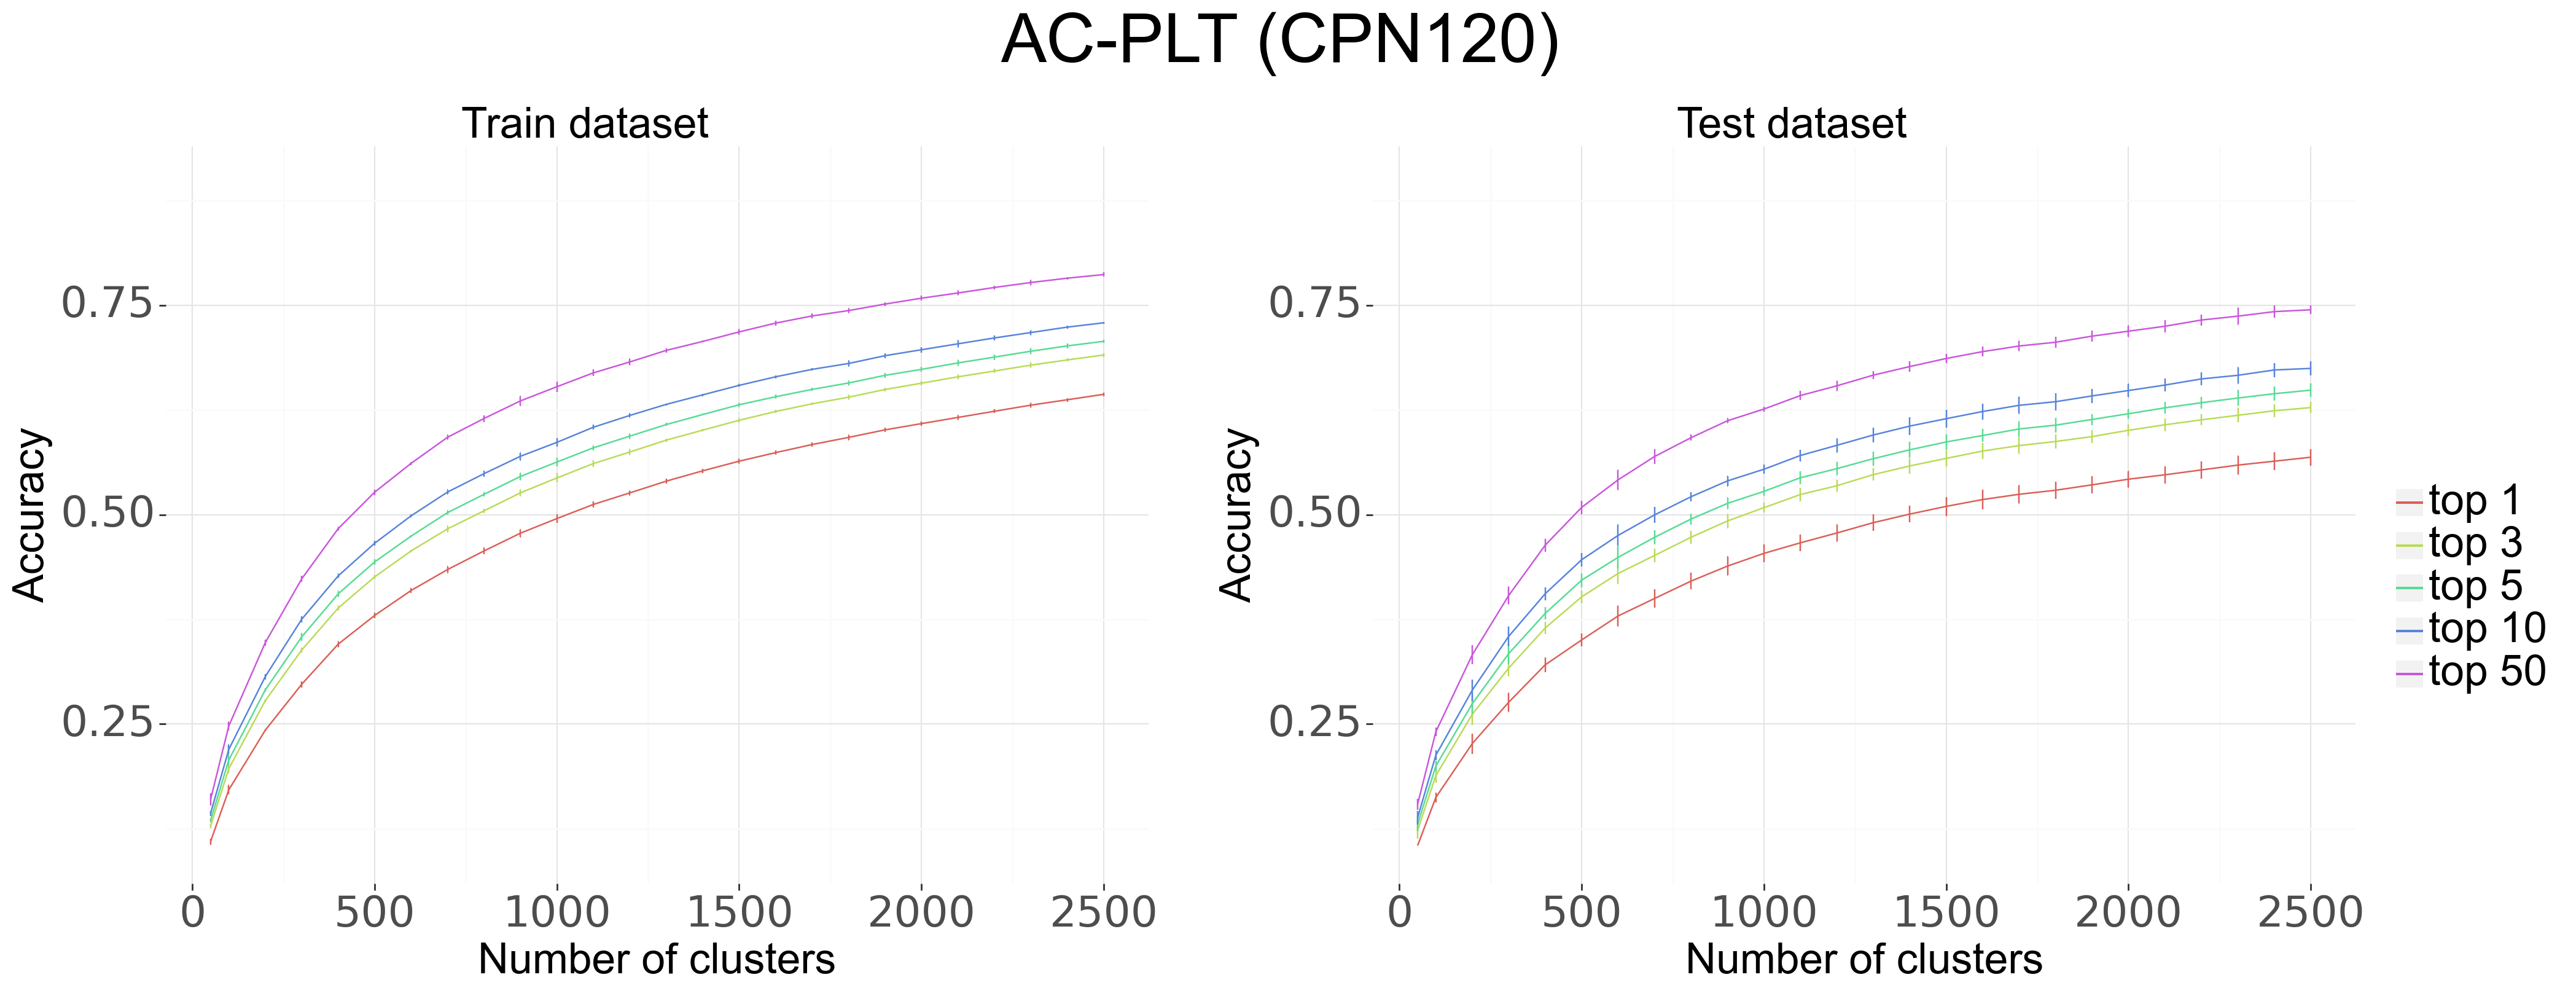

In [ ]:
from numpy import size
from plotnine import *
import patchworklib as pw

rango = [50]+list(range(100,2500+1,100))


# Plot of the accuracy for each k value in the test dataset
p1 = (
    ggplot()+
    aes(x=rango, color='')+
    geom_line(aes(y=k_acc_top_test[:,0], color="'top 1'"))+
    geom_errorbar(aes(ymin = k_acc_top_test[:,0]-k_acc_top_test[:,1], ymax = k_acc_top_test[:,0]+k_acc_top_test[:,1], color="'top 1'"))+
    geom_line(aes(y=k_acc_top_test[:,2], color="'top 3'"))+
    geom_errorbar(aes(ymin = k_acc_top_test[:,2]-k_acc_top_test[:,3], ymax = k_acc_top_test[:,2]+k_acc_top_test[:,3], color="'top 3'"))+
    geom_line(aes(y=k_acc_top_test[:,4], color="'top 5'"))+
    geom_errorbar(aes(ymin = k_acc_top_test[:,4]-k_acc_top_test[:,5], ymax = k_acc_top_test[:,4]+k_acc_top_test[:,5], color="'top 5'"))+
    geom_line(aes(y=k_acc_top_test[:,6], color="'top 10'"))+
    geom_errorbar(aes(ymin = k_acc_top_test[:,6]-k_acc_top_test[:,7], ymax = k_acc_top_test[:,6]+k_acc_top_test[:,7], color="'top 10'"))+
    geom_line(aes(y=k_acc_top_test[:,8], color="'top 50'"))+
    geom_errorbar(aes(ymin = k_acc_top_test[:,8]-k_acc_top_test[:,9], ymax = k_acc_top_test[:,8]+k_acc_top_test[:,9], color="'top 50'"))+
    xlab("Number of clusters")+
    ylab("Accuracy")+
    ggtitle("Test dataset")+
    theme_bw()+
    theme(text=element_text(size=25))+
    scale_y_continuous(limits = (0.1, 0.9))+
    scale_x_continuous(limits=(0, 1550), breaks=range(0, 1501, 250), expand=(0,1))
)

# Plot of the accuracy for each k value in the train dataset
p2 = (
    ggplot()+
    aes(x=rango, color='')+
    geom_line(aes(y=k_acc_top_train[:,0], color="'top 1'"))+
    geom_errorbar(aes(ymin = k_acc_top_train[:,0]-k_acc_top_train[:,1], ymax = k_acc_top_train[:,0]+k_acc_top_train[:,1], color="'top 1'"))+
    geom_line(aes(y=k_acc_top_train[:,2], color="'top 3'"))+
    geom_errorbar(aes(ymin = k_acc_top_train[:,2]-k_acc_top_train[:,3], ymax = k_acc_top_train[:,2]+k_acc_top_train[:,3], color="'top 3'"))+
    geom_line(aes(y=k_acc_top_train[:,4], color="'top 5'"))+
    geom_errorbar(aes(ymin = k_acc_top_train[:,4]-k_acc_top_train[:,5], ymax = k_acc_top_train[:,4]+k_acc_top_train[:,5], color="'top 5'"))+
    geom_line(aes(y=k_acc_top_train[:,6], color="'top 10'"))+
    geom_errorbar(aes(ymin = k_acc_top_train[:,6]-k_acc_top_train[:,7], ymax = k_acc_top_train[:,6]+k_acc_top_train[:,7], color="'top 10'"))+
    geom_line(aes(y=k_acc_top_train[:,8], color="'top 50'"))+
    geom_errorbar(aes(ymin = k_acc_top_train[:,8]-k_acc_top_train[:,9], ymax = k_acc_top_train[:,8]+k_acc_top_train[:,9], color="'top 50'"))+
    xlab("Number of clusters")+
    ylab("Accuracy")+
    ggtitle("Train dataset")+
    theme_bw()+
    theme(legend_position = "none", text=element_text(size=25))+
    scale_y_continuous(limits = (0.1, 0.9))   
)


p1 = pw.load_ggplot(p1, figsize=(8,6))
p2 = pw.load_ggplot(p2, figsize=(8,6))

# Plot of the accuracy for each k value in the train and test dataset
p12 = (p2|p1)
p12.set_text(text="AC-PLT (CPN120)",x=0.42,y=1.1, size=40)
p12.savefig("/your-route/your-file.png")

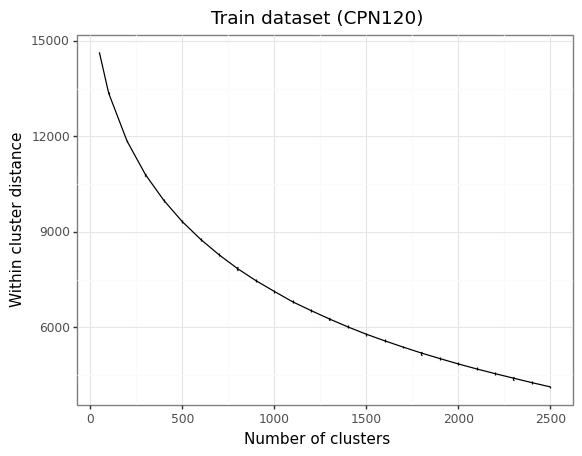

<ggplot: (160220400887)>

In [4]:
from numpy import size
from plotnine import *

# Plot of the inertia for each k
(
    ggplot()+
    aes(x=rango)+
    geom_line(aes(y=k_sse[:,0]))+
    geom_errorbar(aes(ymin = k_sse[:,0]-k_sse[:,1], ymax = k_sse[:,0]+k_sse[:,1]))+
    xlab("Number of clusters")+
    ylab("Within cluster distance")+
    ggtitle("Train dataset (CPN120)")+
    theme_bw()
)

## [Experiments](#experiments)

In [13]:
# Evaluation of the train dataset
from sklearn.model_selection import KFold

kfold=KFold(n_splits=5)
k500_acc_top_train = np.zeros((5, 5))
k500_acc_top_test = np.zeros((5, 5))

tops=(0,2,4,9,49) # The value of the top-p to assess their accurracy

i=0

for train_index, test_index in kfold.split(data_matrix):
    train = data_matrix[train_index, :]
    test = data_matrix[test_index, :]
    
    proc = AC_PLT(n_clusters=1000)
    
    print("iteration:", i+1)
    # Training process
    start = time.time()
    proc.fit(train)
    end = time.time()
    print("Train process time:", end-start)
    
    # Classification process
    start = time.time()
    acc_train = proc.transform(train)
    acc_test = proc.transform(test)
    end = time.time()
    print("Classification process time:", end-start)
    
    for j in range(len(tops)):
        k500_acc_top_train[i,j] = acc_train[tops[j]]
        k500_acc_top_test[i,j] = acc_test[tops[j]]

    i+=1

iteration: 1
Train process time: 12.670350790023804
Classification process time: 99.41445732116699
iteration: 2
Train process time: 11.731065034866333
Classification process time: 93.53732991218567
iteration: 3
Train process time: 10.603864192962646
Classification process time: 102.4691755771637
iteration: 4
Train process time: 13.558097124099731
Classification process time: 112.43091130256653
iteration: 5
Train process time: 12.193648099899292
Classification process time: 95.89402961730957


In [14]:
print(k500_acc_top_train.mean(axis=0))
print(k500_acc_top_train.std(axis=0))

[0.49531608 0.54381125 0.56277466 0.58626512 0.65268022]
[0.0054422  0.00550017 0.00480284 0.00484811 0.00631737]


In [15]:
print(k500_acc_top_test.mean(axis=0))
print(k500_acc_top_test.std(axis=0))

[0.45377269 0.50831688 0.52777451 0.55416803 0.62600432]
[0.01089464 0.00591038 0.00552416 0.0054306  0.00292847]
